<a href="https://colab.research.google.com/github/angelotc/FriedmanIsolationForest/blob/main/FriedmanIsoForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import make_friedman1
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import model_selection 
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

In [2]:
# Helper functions

def add_y_as_feature(X,y):
    X['y1']=y
    return X

def contaminate_df(df1, df2, percentage):
    '''
    Assumes :
    - df1 and df2 have the same number of samples.
    - df1 is the dataset you will train on
    - df2 is the dataset with outliers
    Parameters:
    df1 (df) - dataframe to contaminate
    df2 (df) - dataframe that is contaminated (has noise)
    percentage (float) - Percentage in the form of a float (0,1) . It will add remove this percentage of rows from df1, and add this percentage of the contaminated rows from df2 into df1. 
    For example, if float = 0.05, it will remove the last 5% of the rows in df1, and add the first 5% of the rows from df2 into df1 and return that modified dataframe as the first dataframe.
    The second dataframe that it returns are the samples from df2 that were not added to df1.
    
    Returns:
    three dataframes:
    - modified df1 with contaminated samples
    - the samples from df2 that were not added to df1 (we will save this to use as a training set)
    - the actual outcomes of modified df1
    '''
    assert(len(df1) == len(df2)), "y1 needs to be the same length as y2"
    return df1[:int(len(df2)*(1-percentage))].append(df2[:int(len(df2)*percentage)]), pd.DataFrame([1]*int(len(y1)* (1 - percentage)) + [-1]*int(len(y1)*percentage), columns = ["is_outlier"]), df2[int(len(df2)*percentage):]


# 1. Create our datasets

In [3]:
# Create synthetic dataset using make_friedman1. N = 100k

X1, y1 = make_friedman1(
    n_samples=10000, n_features = 5 , random_state=1)


# Create another synthetic dataset with noise.
X2, y2 = make_friedman1(
    n_samples=10000, n_features = 5, random_state=1, noise=20)

y2 += 30

x_cols = ["x1", "x2", "x3", "x4", "x5"]

In [4]:
# Convert from numpy arrays to pandas dataframes
X1 = pd.DataFrame(X1, columns = ["x1", "x2", "x3", "x4", "x5"])
y1 = pd.DataFrame(y1, columns = ["y1"])
X2 = pd.DataFrame(X2, columns = ["x1", "x2", "x3", "x4", "x5"])
y2 = pd.DataFrame(y2, columns = ["y1"])

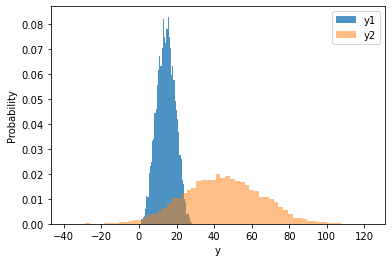

In [5]:
from matplotlib import pyplot as plt
# n_bins = len(X)//100
# We can set the number of bins with the `bins` kwarg

plt.xlabel('y')
plt.ylabel('Probability')

# bins = compute_histogram_bins(y1, 1.0)
plt.hist(y1, bins='auto', alpha=0.8, density = True, label='y1')
plt.hist(y2, bins='auto', alpha=0.5, density = True, label='y2')
plt.legend(loc='upper right')
plt.show()


In [6]:
# Since Isoforest is an unsupervised learning problem, we will need to add the y variable as a feature.

df1 = add_y_as_feature(X1,y1)
df2 = add_y_as_feature(X2,y2)
df1.head(), df2.head()

(         x1        x2        x3        x4        x5         y1
 0  0.417022  0.720324  0.000114  0.302333  0.146756  16.852205
 1  0.092339  0.186260  0.345561  0.396767  0.538817   7.678848
 2  0.419195  0.685220  0.204452  0.878117  0.027388  18.513197
 3  0.670468  0.417305  0.558690  0.140387  0.198101  10.164178
 4  0.800745  0.968262  0.313424  0.692323  0.876389  18.487972,
          x1        x2        x3        x4        x5         y1
 0  0.417022  0.720324  0.000114  0.302333  0.146756   8.850894
 1  0.092339  0.186260  0.345561  0.396767  0.538817  25.843459
 2  0.419195  0.685220  0.204452  0.878117  0.027388  28.970348
 3  0.670468  0.417305  0.558690  0.140387  0.198101  -5.169944
 4  0.800745  0.968262  0.313424  0.692323  0.876389  34.101910)

# 2. To train the model, we need to consider this as a supervised problem


In [21]:
modified_df1,modified_df1_y, test_df2  = contaminate_df(df1, df2, 0.05)

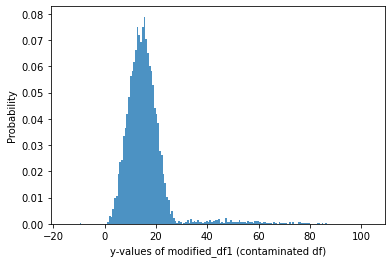

 1    9500
-1     500
Name: is_outlier, dtype: int64


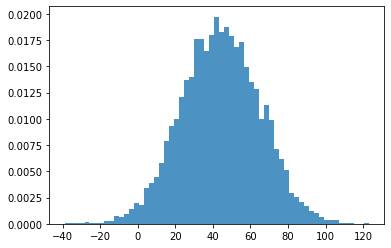

In [30]:
plt.xlabel('y-values of modified_df1 (contaminated df)')
plt.ylabel('Probability')
plt.hist(modified_df1['y1'], bins='auto', alpha=0.8, density = True, label='y1')
plt.show()
print(modified_df1_y["is_outlier"].value_counts())
plt.hist(test_df2['y1'], bins='auto', alpha=0.8, density = True, label='y1')
plt.show()


In [20]:
modified_df1.head()

,x1,x2,x3,x4,x5,y1
0,0.417022,0.720324,0.000114,0.302333,0.146756,16.852205
1,0.092339,0.186260,0.345561,0.396767,0.538817,7.678848
2,0.419195,0.685220,0.204452,0.878117,0.027388,18.513197
3,0.670468,0.417305,0.558690,0.140387,0.198101,10.164178
4,0.800745,0.968262,0.313424,0.692323,0.876389,18.487972


In [50]:
X_train_modified, X_test_modified, y_train_modified, y_test_modified = train_test_split(modified_df1, modified_df1_y, test_size=0.2, random_state=11)

In [ ]:
scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

clf = IsolationForest(random_state=47, contamination = 0.05)

param_grid = {'n_estimators': list(range(100, 200, 5)), 
              'max_samples': list(range(100, 500, 5)),  
              'max_features': list(range(1,6)), 
              'bootstrap': [True, False], 
              'n_jobs': [-1]}


grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring=scoring,
                                                 refit='Recall')

grid_dt_estimator.fit(X_train_modified, y_train_modified)

In [ ]:
# Output best parameters
print(clf.best_params_)